# Fast & Furious: 如何让你的`Python`代码提速
A warm-up: 先来感受一下不同算法的速度差别

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%magic

## Example 1: Linear interpolation
对数进行线性插值

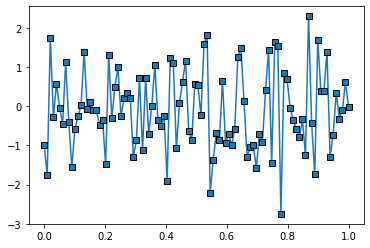

In [3]:
import numpy as np
xdata = np.linspace(0, 1, 100)
ydata = np.random.randn(*xdata.shape)
xsample = np.linspace(0, 1, 100000)
# ysample = ?

figure()
plot(xdata, ydata, 's-', mec="k")

In [4]:
%timeit -r 10 -n 100 np.interp(xsample, xdata, ydata)

573 µs ± 43.2 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [5]:
from scipy.interpolate import interp1d
%timeit -r 10 -n 100 interp1d(xdata, ydata)(xsample)

637 µs ± 30 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [6]:
import bisect
def my_interp1d(xs, x, y):
    ys = np.zeros_like(xs)
    for i, this_xs in enumerate(xs):
        ind = bisect.bisect(x, this_xs)
        ind = min((len(x)-1, ind))
        ys[i] = y[ind-1] + (this_xs-x[ind-1])/(x[ind] - x[ind-1])*(y[ind] - y[ind-1])
    return ys

In [7]:
%timeit -r 1 -n 10 my_interp1d(xsample, xdata, ydata)

167 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [8]:
import bisect
def my_interp1d_vec(xs, x, y):
    ind = np.zeros_like(xs, dtype=int)
    for i, this_xs in enumerate(xs):
        ind[i] = min((bisect.bisect(x, this_xs), len(x)-1))
    ys = y[ind-1] + (xs - x[ind-1])/(x[ind]-x[ind-1])*(y[ind] - y[ind-1])
    return ys

In [9]:
%timeit -r 1 -n 10 my_interp1d_vec(xsample, xdata, ydata)

84.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [10]:
bisect.bisect(np.arange(10), 10)

10

ND-Linear interpolation (faster than `scipy`): https://github.com/hypergravity/regli

## Example 2: inner product
矢量内积 $\vec{a} \cdot \vec{b} = \sum_i a_i \times b_i$

In [11]:
nel = 100
a = np.random.randn(nel)
b = np.random.randn(nel)

In [12]:
def my_dot(a, b):
    c = 0
    for i in range(len(a)):
        c += a[i]*b[i]
    return c

In [13]:
%timeit -r 100 -n 1000 my_dot(a, b)

23.5 µs ± 2.72 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)


In [14]:
%timeit -r 100 -n 1000 np.sum(a * b)

4.29 µs ± 475 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)


In [15]:
%timeit -r 100 -n 1000 np.matmul(a.reshape(1, -1), b.reshape(-1, 1))

1.31 µs ± 126 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)


In [16]:
%timeit -r 100 -n 1000 np.dot(a, b)

963 ns ± 265 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)


## Example 3: acceleration using `numba`
那么是不是所有的程序都不要自己写？不是！

In [17]:
from numba import jit

@jit(nopython=True)
def my_dot_numba(a, b):
    c = 0
    for i in range(len(a)):
        c += a[i]*b[i]
    return c

my_dot_numba(a, b);

In [18]:
%timeit -r 100 -n 1000 my_dot_numba(a, b)

474 ns ± 57.5 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)


In [19]:
@jit(nopython=True)
def numba_dot(a, b):
    return np.dot(a, b)

numba_dot(a, b);

In [20]:
%timeit -r 100 -n 1000 numba_dot(a, b)

405 ns ± 31.5 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)


Note that, `numba` supports only some of `numpy` operations... 

See [https://numba.pydata.org/numba-doc/latest/reference/numpysupported.html#](https://numba.pydata.org/numba-doc/latest/reference/numpysupported.html#)

For other methods for accelerations:
- [NumExpr](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/intro.html): string compiled to objects
- [Cython](https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html): C python speed limit
- [f2py](https://numpy.org/doc/stable/f2py/): fortran to python

## Example 4: optimization
- free variables $\vec{x} = [a, b]$
- observables $\vec{y} = [a+b, a-b]$

In [21]:
# define problem
def model(x):
    a, b = x
    return a+b, a-b

yobs = np.array([10, 2]) # so truth of x is [6, 4]
x0 = np.zeros(2, float)  # initial guess of x

#### Solution 1: `scipy.optimize.least_squares`

In [22]:
from scipy.optimize import least_squares
def res(x, y):
    return model(x) - y

In [23]:
%timeit -r 10 -n 100 least_squares(res, x0, args=(yobs,), method="trf")

1.19 ms ± 62.6 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [24]:
%timeit -r 10 -n 100 least_squares(res, x0, args=(yobs,), method="dogbox")    

1.08 ms ± 61.8 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [25]:
%timeit -r 10 -n 100 least_squares(res, x0, args=(yobs,), method="lm")    

277 µs ± 32.1 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


#### Solution 2: `scipy.optimize.minimize`

In [26]:
from scipy.optimize import minimize
def chi2(x, y):
    res = (model(x) - y)
    return .5 * np.dot(res, res)

In [27]:
%timeit -r 10 -n 100 minimize(chi2, x0, args=(yobs,), method="BFGS")    

713 µs ± 44.2 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [28]:
%timeit -r 10 -n 100 minimize(chi2, x0, args=(yobs,), method="Powell")  

531 µs ± 30.7 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [29]:
%timeit -r 10 -n 100 minimize(chi2, x0, args=(yobs,), method="Nelder-Mead")    

3 ms ± 190 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


![](https://scipy-lectures.org/_images/sphx_glr_plot_compare_optimizers_001.png)

From `scipy`-lectures: https://scipy-lectures.org/advanced/mathematical_optimization/#practical-guide-to-optimization-with-scipy

## Example 5: maximize the CPU usage
记不记得i9其实有8个core？为何不物尽其用
- multiprocessing: https://docs.python.org/3/library/multiprocessing.html
- joblib: https://joblib.readthedocs.io/en/latest/
- ipyparallel

In [30]:
import time
def one_task(x=1):
    time.sleep(1)
    return x**2

### Normal case

In [31]:
%time one_task(1)

CPU times: user 533 µs, sys: 628 µs, total: 1.16 ms
Wall time: 1 s


1

In [32]:
%%time
for i in range(5):
    one_task(i)

CPU times: user 1.03 ms, sys: 1.17 ms, total: 2.2 ms
Wall time: 5.01 s


### With `multiprocessing`

In [33]:
# from multiprocessing import Pool
# with Pool(3) as p:
#     print(p.map(one_task, [1, 2, 3]))

KeyboardInterrupt: 

Well, I just can't make it work...

### With `joblib`

In [34]:
import joblib
%time result = joblib.Parallel(n_jobs=5, verbose=1, backend="loky")(joblib.delayed(one_task)(i) for i in range(20))
print(result)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


CPU times: user 29.8 ms, sys: 55 ms, total: 84.9 ms
Wall time: 4.31 s
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]


[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.3s finished


### With `ipyparallel`

In [35]:
from ipyparallel import Client
rc = Client(profile="default")
print(rc.ids)

[0, 1, 2, 3, 4]


/Users/cham/anaconda3/lib/python3.8/site-packages/ipyparallel/util.py:218: RuntimeWarning: IPython could not determine IPs for MBP16: [Errno 8] nodename nor servname provided, or not known
  warnings.warn(


In [36]:
# make direct view
dv = rc[:]
dv.block = True

In [37]:
# make data
xdata = range(20)
ydata = np.random.randn(20)

In [38]:
# push
dv.push({"x": xdata})
print(dv["x"])

[range(0, 20), range(0, 20), range(0, 20), range(0, 20), range(0, 20)]


In [39]:
# scatter
dv.scatter("x", xdata)
print(dv["x"])

[range(0, 4), range(4, 8), range(8, 12), range(12, 16), range(16, 20)]


In [40]:
# push the function as well
dv.push({"one_task": one_task})

[None, None, None, None, None]

In [41]:
# remember to import modules in the remote engines
dv.execute("import time")

<AsyncResult: execute:finished>

In [42]:
# do the tasks in remote engines
dv.execute("result = [one_task(_) for _ in x]")

<AsyncResult: execute:finished>

In [43]:
# check time cost
%time dv.execute("result = [one_task(_) for _ in x]")

CPU times: user 9.14 ms, sys: 2.72 ms, total: 11.9 ms
Wall time: 4.03 s


<AsyncResult: execute:finished>

In [44]:
# take a look at the results
dv["result"]

[[0, 1, 4, 9],
 [16, 25, 36, 49],
 [64, 81, 100, 121],
 [144, 169, 196, 225],
 [256, 289, 324, 361]]

In [45]:
# gather results
dv.gather("result")

[0,
 1,
 4,
 9,
 16,
 25,
 36,
 49,
 64,
 81,
 100,
 121,
 144,
 169,
 196,
 225,
 256,
 289,
 324,
 361]